## This notebook pulls in the h5 and attemps to annotate what can be annotated
### By, James Barfield

In [3]:
import rosbag
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
import PIL
import os
import glob
import csv
import h5py
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [4]:
h5_directory = '/home/james/bagfiles/Track_Images.h5'
data = h5py.File(h5_directory, 'r')

In [5]:
# List all the top level keys
keys = []
for key in data.keys():
    print(key)
    keys.append(str(key))

Training_Data


In [6]:
print(data['Training_Data/Images_RGB'])
print(data['Training_Data/image_class'])

<HDF5 dataset "Images_RGB": shape (3022, 600, 800, 3), type "|u1">
<HDF5 dataset "image_class": shape (3023,), type "<f8">


2.0


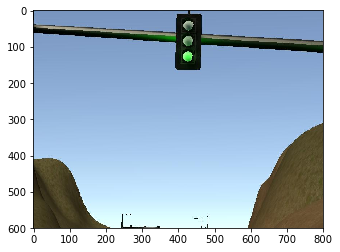

In [7]:
# lets load a random image and class into memory
ind =np.random.randint(0,data['Training_Data/Images_RGB'].shape[0])
print(data['Training_Data/image_class'][ind])
plt.imshow(data['Training_Data/Images_RGB'][ind])
# Red_light:0 Yellow_light:1 Green_light:2 Dontuse: 3 no_light: 4

## Attempt to segement an image

0.0


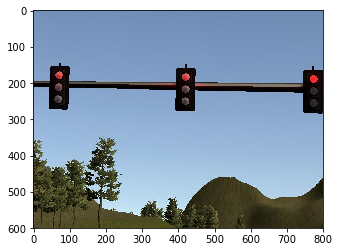

In [8]:
ind = 2536 # single light, green
ind = 2765 # single light red
ind = 2867 # single yellow
# ind = 2528
ind = 363
# ind =np.random.randint(0,data['Training_Data/Images_RGB'].shape[0])

Image_class = data['Training_Data/image_class'][ind]
Image_RGB = data['Training_Data/Images_RGB'][ind]
print(Image_class)
plt.imshow(Image_RGB)

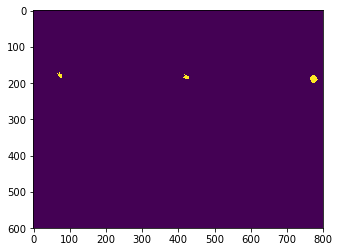

In [10]:
if Image_class == 0.0: # red
    lower_black = np.array([200,0,0], dtype = "uint8")
    upper_black = np.array([255,100,100], dtype = "uint8")
    vertical_bb_scaler = -30
elif Image_class == 2.0: #green
    lower_black = np.array([0,170,0], dtype = "uint8")
    upper_black = np.array([150,255,150], dtype = "uint8")
    vertical_bb_scaler = 30
elif Image_class == 1.0: # yellow
    lower_black = np.array([200,200,0], dtype = "uint8")
    upper_black = np.array([255,255,100], dtype = "uint8")
    vertical_bb_scaler = 0
Light_mask = cv2.inRange(Image_RGB, lower_black, upper_black)

plt.imshow(Light_mask)

In [11]:
# now i'm going to go from image space to x,y and cluster 
# then draw boxes arround lights 
# then annotate the areas in the boxes within a certain color threshold

# print Light_mask[140:160,420:480]
X = []
for x in range(0, Light_mask.shape[0]):
    for y in range(0, Light_mask.shape[1]):
        if Light_mask[x,y]>0:
            X.append([x,y])

X = np.array(X)

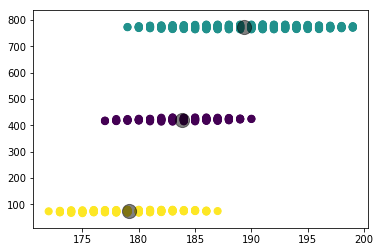

In [18]:
# kmeans the x,y

# using DBscan to find the number of lights
db = DBSCAN(eps=.3,min_samples=5)
Xp = StandardScaler().fit_transform(X)
db.fit(Xp)
y_pred = db.labels_.astype(np.int)
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

# kmeans to determine the centroid
kmeans = KMeans(n_clusters=n_clusters_)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [19]:
x_pixels = centers[:, 0]
y_pixels = centers[:, 1]

In [20]:
# lets draw some bounding boxes based on how high the light is in the image 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [21]:
# determiine the size of the box based on height 
x_plus_scaler = ((65+vertical_bb_scaler))
x_mins_scaler = ((65-vertical_bb_scaler))
# offset the box based on color

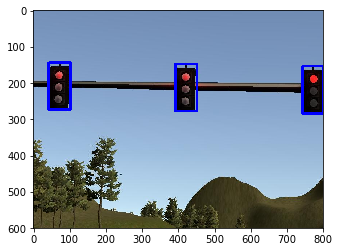

In [22]:
window_list = []
for i in range(0,len(x_pixels)):
    startx = int(x_pixels[i]) - int(x_plus_scaler* np.log(600-x_pixels[i])/6)
    if(startx<0):
        startx = 0
    starty = int(y_pixels[i]) - int(30*np.log(600-x_pixels[i])/6)
    if(starty<0):
        starty = 0
    endx = int(x_pixels[i]) + int(x_mins_scaler*np.log(600-x_pixels[i])/6)
    if(endx>Image_RGB.shape[0]):
        endx = mage_RGB.shape[0]
    endy = int(y_pixels[i]) + int(30*np.log(600-x_pixels[i])/6)
    if(endy>Image_RGB.shape[1]):
        endy = Image_RGB.shape[1]
        
    
    window_list.append(((starty, startx), (endy, endx)))
img_box=draw_boxes(Image_RGB, window_list)
plt.imshow(img_box)  

In [86]:

Image_output_dir =  '/home/james/bagfiles/BB'
Annot_output_dir = '/home/james/bagfiles/Annotations'
Annot_output_training = '/home/james/bagfiles/training'

for ind in range(0,data['Training_Data/Images_RGB'].shape[0]):
    # load the image
    Image_class = data['Training_Data/image_class'][ind]
    Image_RGB = data['Training_Data/Images_RGB'][ind]
    
    if (Image_class == 0.0 or Image_class == 1.0 or Image_class == 2.0):
    
        # based on class, color filter
        if Image_class == 0.0: # red
            lower_black = np.array([200,0,0], dtype = "uint8")
            upper_black = np.array([255,100,100], dtype = "uint8")
            vertical_bb_scaler = -30
        elif Image_class == 2.0: #green
            lower_black = np.array([0,170,0], dtype = "uint8")
            upper_black = np.array([150,255,150], dtype = "uint8")
            vertical_bb_scaler = 30
        elif Image_class == 1.0: # yellow
            lower_black = np.array([200,200,0], dtype = "uint8")
            upper_black = np.array([255,255,100], dtype = "uint8")
            vertical_bb_scaler = 0
        Light_mask = cv2.inRange(Image_RGB, lower_black, upper_black)

        # using DBscan to find the number of lights
        
        X = []
        for x in range(0, Light_mask.shape[0]):
            for y in range(0, Light_mask.shape[1]):
                if Light_mask[x,y]>0:
                    X.append([x,y])

        X = np.array(X)
        if X.shape[0] > 0:

            db = DBSCAN(eps=.28,min_samples=10)
            Xp = StandardScaler().fit_transform(X)
            db.fit(Xp)
            n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

            if n_clusters_>0:

                # kmeans to determine the centroid
                kmeans = KMeans(n_clusters=n_clusters_)
                kmeans.fit(X)
                y_kmeans = kmeans.predict(X)
                centers = kmeans.cluster_centers_

                x_pixels = centers[:, 0]
                y_pixels = centers[:, 1]

                # determiine the size of the box based on height 
                x_plus_scaler = ((65+vertical_bb_scaler))
                x_mins_scaler = ((65-vertical_bb_scaler))

                window_list = []
                fh = open(os.path.join(Annot_output_dir, "%06i.txt" % ind), 'w') 

                for i in range(0,len(x_pixels)):
                    startx = int(x_pixels[i]) - int(x_plus_scaler* np.log(600-x_pixels[i])/6)
                    if(startx<0):
                        startx = 0
                    starty = int(y_pixels[i]) - int(30*np.log(600-x_pixels[i])/6)
                    if(starty<0):
                        starty = 0
                    endx = int(x_pixels[i]) + int(x_mins_scaler*np.log(600-x_pixels[i])/6)
                    if(endx>Image_RGB.shape[0]):
                        endx = mage_RGB.shape[0]
                    endy = int(y_pixels[i]) + int(30*np.log(600-x_pixels[i])/6)
                    if(endy>Image_RGB.shape[1]):
                        endy = Image_RGB.shape[1]
                    window_list.append(((starty, startx), (endy, endx)))
    #                 Red 0.0 0 0.0 x_min y_min x_max y_max 0.0 0.0 0.0 0.0 0.0 0.0 0.0
                    if Image_class == 0.0: # red
                        fh.writelines('Red 0.0 0 0.0 ' +str(starty)+ ' ' +str(startx)+ ' '+ str(endy)+ ' ' + str(endx)+' 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n') 
                    elif Image_class == 2.0: #green
                        fh.writelines('Green 0.0 0 0.0 ' +str(starty)+ ' ' +str(startx)+ ' '+ str(endy)+ ' ' + str(endx)+' 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n') 
                    elif Image_class == 1.0: # yellow
                        fh.writelines('Yellow 0.0 0 0.0 ' +str(starty)+ ' ' +str(startx)+ ' '+ str(endy)+ ' ' + str(endx)+' 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n') 

                fh.close() 

                # draw some BB's


                if Image_class == 0.0: # red
                    img_box=draw_boxes(Image_RGB, window_list,color=(255, 0, 0))
                elif Image_class == 2.0: #green
                    img_box=draw_boxes(Image_RGB, window_list,color=(0, 255, 0))
                elif Image_class == 1.0: # yellow
                    img_box=draw_boxes(Image_RGB, window_list,color=(255, 255, 0))
                #write the image
                cv2.imwrite(os.path.join(Image_output_dir, "%06i.png" % ind), cv2.cvtColor(img_box, cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(Annot_output_training, "%06i.png" % ind),  cv2.cvtColor(Image_RGB, cv2.COLOR_RGB2BGR),  [cv2.IMWRITE_PNG_COMPRESSION, 0])



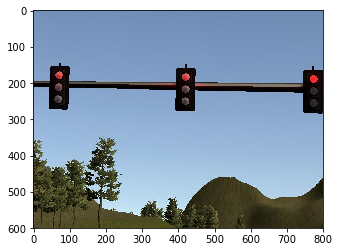

In [24]:
plt.imshow(Image_RGB);


In [25]:
# testing thresholding 
lower_black = np.array([200,0,0], dtype = "uint8")
upper_black = np.array([255,100,100], dtype = "uint8")
Red_mask = cv2.inRange(Image_RGB, lower_black, upper_black)
lower_black = np.array([0,170,0], dtype = "uint8")
upper_black = np.array([150,255,150], dtype = "uint8")
Green_mask = cv2.inRange(Image_RGB, lower_black, upper_black)
lower_black = np.array([200,200,0], dtype = "uint8")
upper_black = np.array([255,255,100], dtype = "uint8")
Yellow_mask = cv2.inRange(Image_RGB, lower_black, upper_black)

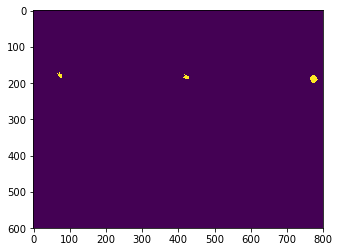

In [26]:
plt.imshow(Red_mask);

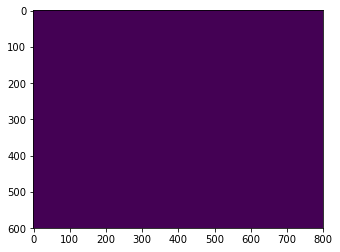

In [27]:
plt.imshow(Green_mask);

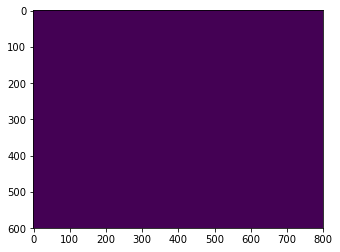

In [28]:
plt.imshow(Yellow_mask);

In [31]:
print np.sum(Yellow_mask)
print np.sum(Green_mask)
print np.sum(Red_mask)

0
0
144585


# writing a simple color based classificaiton

In [33]:
    def get_classification(image):

        lower_black = np.array([200,0,0], dtype = "uint8")
        upper_black = np.array([255,100,100], dtype = "uint8")
        Red_sum = np.sum(cv2.inRange(image, lower_black, upper_black))
        lower_black = np.array([0,170,0], dtype = "uint8")
        upper_black = np.array([150,255,150], dtype = "uint8")
        Green_sum = np.sum(cv2.inRange(image, lower_black, upper_black))
        lower_black = np.array([200,200,0], dtype = "uint8")
        upper_black = np.array([255,255,100], dtype = "uint8")
        Yellow_sum = np.sum(cv2.inRange(image, lower_black, upper_black))

        if (Red_sum < 500) and (Green_sum < 500) and (Yellow_sum < 500): # 500 is a threshold meaning probabbly not a light
            return 3
        elif (Red_sum > Green_sum): 
            if (Red_sum > Yellow_sum):
                return 0
            else:
                return 1

        elif (Yellow_sum > Green_sum):
            if (Yellow_sum > Red_sum):
                return 1
            else:
                return 0
        else:
            return 2

In [30]:
get_classification(Image_RGB)

0